# Annotate merged single cells with metadata from platemap file

## Import libraries

In [1]:
import pathlib
import sys

import lancedb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pycytominer import annotate
from pycytominer.cyto_utils import output

/home/lippincm/miniforge3/envs/cellprofiler_timelapse_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def euclidean_coordinate_fuzzy_match(
    df_left: pd.DataFrame,
    df_right: pd.DataFrame,
    left_on: list,
    right_on: list,
    coordinate_column: str,
    unique_image_column: str,
    pixel_cutt_off: int = 5,
) -> pd.DataFrame:
    """
    This function fuzzy merges two dataframes based on the euclidean distance between the coordinates in the coordinate_column.

    Parameters
    ----------
    df_left : pd.DataFrame
        left dataframe to merge
    df_right : pd.DataFrame
        right dataframe to merge
    left_on : list
        Left dataframe columns to match on
    right_on : list
        Right dataframe columns to match on
    coordinate_column : str
        The column name that contains the coordinates to match on
        Note that the coordinates should be in a tuple format
    unique_image_column : str
        The column name that contains the unique image identifier to split the dataframes on
        This ensures that coordinates from other images are not matched together

    Returns
    -------
    pd.DataFrame
        A merged dataframe of the two input dataframes based on the euclidean distance between the coordinates
    """
    # split the each data fram into each cell_merge_column
    all_images = df_left[unique_image_column].unique()

    merged_df_list = []
    total_CP_cells = 0
    total_annotated_cells = 0
    distances = []

    for image in all_images:
        subset_df_left = df_left[df_left[unique_image_column] == image]
        subset_df_right = df_right[df_right[unique_image_column] == image]
        total_CP_cells += subset_df_left.shape[0]
        # loop through the rows in the subset_annotated_df and find the closest coordinate set in the location metadata
        for index1, row1 in subset_df_left.iterrows():
            dist = np.inf
            for index2, row2 in subset_df_right.iterrows():
                coord1 = row1[coordinate_column]
                coord2 = row2[coordinate_column]
                try:
                    temp_dist = np.linalg.norm(np.array(coord1) - np.array(coord2))
                except:
                    temp_dist = np.inf
                if temp_dist <= dist:
                    dist = temp_dist
                    coord2_index = index2

            # set cut off of 5,5 pixel in the euclidean distance
            euclidean_cut_off = np.linalg.norm(
                np.array([0, 0]) - np.array([pixel_cutt_off, pixel_cutt_off])
            )

            if dist < np.inf:
                temp_merged_df = pd.merge(
                    subset_df_left.loc[[index1]],
                    subset_df_right.loc[[coord2_index]],
                    how="inner",
                    left_on=right_on,
                    right_on=left_on,
                )
                distances.append(dist)
                total_annotated_cells += temp_merged_df.shape[0]
                merged_df_list.append(temp_merged_df)
    if len(merged_df_list) == 0:
        return pd.DataFrame()
    merged_df = pd.concat(merged_df_list)
    merged_df["distance"] = distances
    print(f"Percentage of annotated cells: {total_annotated_cells/total_CP_cells*100}%")
    return merged_df

## Set paths and variables

In [3]:
# load in platemap file as a pandas dataframe
platemap_path = pathlib.Path("../../data/").resolve()

# directory where parquet files are located
data_dir = pathlib.Path("../data/converted_data")

# directory where the annotated parquet files are saved to
output_dir = pathlib.Path("../data/annotated_data")
output_dir.mkdir(exist_ok=True)

In [4]:
# dictionary with each run for the cell type
dict_of_inputs = {
    "run_20231017ChromaLive_6hr_4ch_MaxIP": {
        "source_path": pathlib.Path(
            f"{data_dir}/20231017ChromaLive_6hr_4ch_MaxIP.parquet"
        ).resolve(strict=True),
        "platemap_path": pathlib.Path(f"{platemap_path}/platemap_6hr_4ch.csv").resolve(
            strict=True
        ),
    },
    "20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP": {
        "source_path": pathlib.Path(
            f"{data_dir}/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP.parquet"
        ).resolve(strict=True),
        "platemap_path": pathlib.Path(
            f"{platemap_path}/platemap_AnnexinV_2ch.csv"
        ).resolve(strict=True),
    },
}

## Annotate merged single cells

In [5]:
for data_run, info in dict_of_inputs.items():
    # load in converted parquet file as df to use in annotate function
    single_cell_df = pd.read_parquet(info["source_path"])
    print(single_cell_df.shape)
    single_cell_df = single_cell_df.rename(
        columns={
            "Image_Metadata_FOV": "Metadata_FOV",
            "Image_Metadata_Time": "Metadata_Time",
        },
    )
    platemap_df = pd.read_csv(info["platemap_path"])
    output_file = str(pathlib.Path(f"{output_dir}/{data_run}_sc.parquet"))
    print(f"Adding annotations to merged single cells for {data_run}!")

    # add metadata from platemap file to extracted single cell features
    annotated_df = annotate(
        profiles=single_cell_df,
        platemap=platemap_df,
        join_on=["Metadata_well", "Image_Metadata_Well"],
    )
    print(annotated_df.shape)

    # move metadata well and single cell count to the front of the df (for easy visualization in python)
    well_column = annotated_df.pop("Metadata_Well")
    singlecell_column = annotated_df.pop("Metadata_number_of_singlecells")
    # insert the column as the second index column in the dataframe
    annotated_df.insert(1, "Metadata_Well", well_column)
    annotated_df.insert(2, "Metadata_number_of_singlecells", singlecell_column)

    # rename metadata columns to match the expected column names
    columns_to_rename = {
        "Nuclei_Location_Center_Y": "Metadata_Nuclei_Location_Center_Y",
        "Nuclei_Location_Center_X": "Metadata_Nuclei_Location_Center_X",
    }
    # Image_FileName cols
    for col in annotated_df.columns:
        if "Image_FileName" in col:
            columns_to_rename[col] = f"Metadata_{col}"
        elif "Image_PathName" in col:
            columns_to_rename[col] = f"Metadata_{col}"
        elif "TrackObjects" in col:
            columns_to_rename[col] = f"Metadata_{col}"
    # rename metadata columns
    annotated_df.rename(columns=columns_to_rename, inplace=True)

    # save annotated df as parquet file
    output(
        df=annotated_df,
        output_filename=output_file,
        output_type="parquet",
    )
    print(f"Annotations have been added to {data_run} and saved to {output_file}")
    # check last annotated df to see if it has been annotated correctly
    print(annotated_df.shape)
    annotated_df.head()
del annotated_df

(19382, 2321)
Adding annotations to merged single cells for run_20231017ChromaLive_6hr_4ch_MaxIP!
(19382, 2325)
Annotations have been added to run_20231017ChromaLive_6hr_4ch_MaxIP and saved to ../data/annotated_data/run_20231017ChromaLive_6hr_4ch_MaxIP_sc.parquet
(19382, 2325)
(838, 1204)
Adding annotations to merged single cells for 20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP!
(838, 1208)
Annotations have been added to 20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP and saved to ../data/annotated_data/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_sc.parquet
(838, 1208)


### Merge the terminal and single cell data

## Add the object tacking from SAM2

### Loop through the saved annotated dfs and add the object tracking

Location metadata shape for run_20231017ChromaLive_6hr_4ch_MaxIP is (14882, 9)
/home/lippincm/Documents/live_cell_timelapse_apoptosis/5.process_CP_features/data/annotated_data/run_20231017ChromaLive_6hr_4ch_MaxIP_sc.parquet
Oringinal shape of run_20231017ChromaLive_6hr_4ch_MaxIP is (19382, 2325)
There were 4807 NaN values in the centroid columns
(14575, 2328) (14882, 11)


/tmp/ipykernel_261847/1581231095.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df['distance'] = distances


Percentage of annotated cells: 100.0%
(14575, 2334)
The average distance between the annotated and CP data is 5.293905628142523
The std of the distance between the annotated and CP data is 5.516932893853417
The threshold for the distance between the annotated and CP data is 16.327771415849355


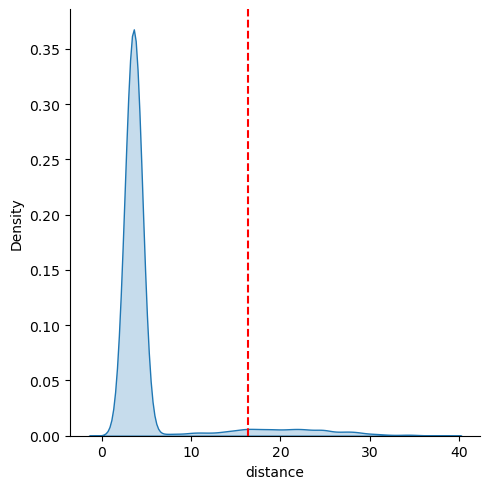

Removed 1078 cells above the threshold
Location metadata shape for 20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP is (675, 9)
/home/lippincm/Documents/live_cell_timelapse_apoptosis/5.process_CP_features/data/annotated_data/20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP_sc.parquet
Oringinal shape of 20231017ChromaLive_endpoint_w_AnnexinV_2ch_MaxIP is (838, 1208)
There were 149 NaN values in the centroid columns
(689, 1211) (675, 11)
Percentage of annotated cells: 100.0%
(689, 1217)
Removed 356 cells above the threshold


/tmp/ipykernel_261847/1581231095.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_df['distance'] = distances


In [6]:
for data_run in dict_of_inputs.keys():
    ##############################################
    # load in location metadata file as a pandas dataframe
    # set and connect to the db
    # create the database object
    uri = pathlib.Path("../../data/objects_db").resolve()
    db = lancedb.connect(uri)
    # load table
    table = db["1.masked_images"]
    location_metadata_df = table.to_pandas()
    location_metadata_df.head()
    # change frame to Metadata_Time
    location_metadata_df = location_metadata_df.rename(
        columns={"frame": "Metadata_Time"}
    )
    # add 1 to Metadata_Time to match the timepoints in the single cell data
    location_metadata_df["Metadata_Time"] = location_metadata_df["Metadata_Time"] + 1
    # change formatting to leading 4 zeros
    location_metadata_df["Metadata_Time"] = location_metadata_df["Metadata_Time"].apply(
        lambda x: f"{x:04}"
    )
    location_metadata_df["Metadata_unique_cell_name"] = (
        location_metadata_df["image_set_name"]
        + "_"
        + location_metadata_df["object_id"].astype(str)
    )
    for col in location_metadata_df.columns:
        if not col.startswith("Metadata_"):
            location_metadata_df = location_metadata_df.rename(
                columns={col: f"Metadata_{col}"}
            )

    ##############################################
    if "endpoint" in data_run:
        # get only the endpoint timepoint for the endpoint data
        location_metadata_df = location_metadata_df[
            location_metadata_df["Metadata_Time"] == "0014"
        ]
    elif "endpoint" not in data_run:
        # remove the endpoint timepoint for the 6hr data
        location_metadata_df = location_metadata_df[
            location_metadata_df["Metadata_Time"] != "0014"
        ]
    print(f"Location metadata shape for {data_run} is {location_metadata_df.shape}")
    # load in annotated parquet file as df to use in annotate function
    annotated_df_path = pathlib.Path(f"{output_dir}/{data_run}_sc.parquet").resolve(
        strict=True
    )
    output_file = annotated_df_path

    print(annotated_df_path)
    annotated_df = pd.read_parquet(annotated_df_path)
    print(f"Oringinal shape of {data_run} is {annotated_df.shape}")

    annotated_df["Metadata_image_set_name"] = (
        annotated_df["Metadata_Well"].astype(str)
        + "_"
        + "F"
        + annotated_df["Metadata_FOV"].astype(str)
    )

    image_set_names = annotated_df.pop("Metadata_image_set_name")
    # move to front
    time = annotated_df.pop("Metadata_Time")
    x_coord = annotated_df.pop("Metadata_Nuclei_Location_Center_X")
    y_coord = annotated_df.pop("Metadata_Nuclei_Location_Center_Y")

    annotated_df = pd.concat(
        [image_set_names, annotated_df, time, x_coord, y_coord], axis=1
    )

    num_cells_over_time = annotated_df.shape[0]
    # drop NaN values in the centroid columns from annotated_df
    annotated_df = annotated_df.dropna(
        subset=[
            "Metadata_Nuclei_Location_Center_X",
            "Metadata_Nuclei_Location_Center_Y",
        ]
    )
    print(
        f"There were {num_cells_over_time - annotated_df.shape[0]} NaN values in the centroid columns"
    )

    # round the float coordinates to integers
    annotated_df["Metadata_Nuclei_Location_Center_X"] = (
        annotated_df["Metadata_Nuclei_Location_Center_X"].round(0).astype(int)
    )
    annotated_df["Metadata_Nuclei_Location_Center_Y"] = (
        annotated_df["Metadata_Nuclei_Location_Center_Y"].round(0).astype(int)
    )

    location_metadata_df["Metadata_x"] = location_metadata_df["Metadata_x"].astype(int)
    location_metadata_df["Metadata_y"] = location_metadata_df["Metadata_y"].astype(int)

    # Create new columns in a separate DataFrame
    new_columns = pd.DataFrame(
        {
            "Metadata_individual_images": annotated_df["Metadata_image_set_name"]
            + "_"
            + annotated_df["Metadata_Time"].astype(str),
            "Metadata_coordinates": list(
                zip(
                    annotated_df["Metadata_Nuclei_Location_Center_X"],
                    annotated_df["Metadata_Nuclei_Location_Center_Y"],
                )
            ),
        }
    )

    # Concatenate the new columns with the original DataFrame
    annotated_df = pd.concat([annotated_df, new_columns], axis=1)

    location_metadata_df["Metadata_individual_images"] = (
        location_metadata_df["Metadata_image_set_name"]
        + "_"
        + location_metadata_df["Metadata_Time"].astype(str)
    )
    location_metadata_df["Metadata_coordinates"] = list(
        zip(location_metadata_df["Metadata_x"], location_metadata_df["Metadata_y"])
    )

    print(annotated_df.shape, location_metadata_df.shape)

    # the terminal data shifted largely due to the plate being moved!
    # dead cells really shifted and are no longer in the same location or close and thus not trackable

    merged_df = euclidean_coordinate_fuzzy_match(
        df_left=annotated_df,
        df_right=location_metadata_df,
        left_on=[
            "Metadata_individual_images",
            "Metadata_Time",
            "Metadata_image_set_name",
        ],
        right_on=[
            "Metadata_individual_images",
            "Metadata_Time",
            "Metadata_image_set_name",
        ],
        coordinate_column="Metadata_coordinates",
        unique_image_column="Metadata_individual_images",
    )
    if merged_df.empty:
        print(f"No cells were matched for {data_run}")
        continue
    # sort by image_set_name and Metadata_Time
    merged_df = merged_df.sort_values(by=["Metadata_image_set_name", "Metadata_Time"])
    merged_df = merged_df.drop(
        columns=[
            "Metadata_individual_images",
            "Metadata_coordinates_x",
            "Metadata_coordinates_y",
        ]
    )
    print(merged_df.shape)
    # this sets the threshold for the main dataset and applies it to the endpoint dataset

    threshold = 14
    if not "endpoint" in data_run:

        # find the density average of the distance
        print(
            f"The average distance between the annotated and CP data is {merged_df['distance'].mean()}"
        )
        # find the std of the distance
        print(
            f"The std of the distance between the annotated and CP data is {merged_df['distance'].std()}"
        )
        # set the threshold to mean + 2*std
        threshold = merged_df["distance"].mean() + 2 * merged_df["distance"].std()
        print(
            f"The threshold for the distance between the annotated and CP data is {threshold}"
        )

        # density plot of the annotated data
        sns.displot(merged_df["distance"], kind="kde", fill=True)
        # add the threshold line
        plt.axvline(x=threshold, color="red", linestyle="--")
        plt.show()
        # remove the cells that are above the threshold
    number_of_cells = merged_df.shape[0]
    merged_df = merged_df[merged_df["distance"] <= threshold]
    print(f"Removed {number_of_cells - merged_df.shape[0]} cells above the threshold")
    # save annotated df as parquet file
    output(
        df=merged_df,
        output_filename=output_file,
        output_type="parquet",
    )
    del merged_df
    del annotated_df
    del location_metadata_df